# PROJECT ON BUSINESS SETUP FOR AN INDIAN RESTAURANT IN DUBAI

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction  <a name="introduction"></a>

#### Business Problem:
This study is focused to detect a prime location in Dubai to set up an Indian cuisine restaurant, particularly walking distance from the Metro station. Our study is based on the following attributes in vicinity of each Metro station as mentioned below.
* Number of Indian restaurants, other Restaurants  and Hotels
* Population density
* House price index
* Tourist attractions

Dubai is a well-known tourist destination and hence hospitality industry has become the most prominent sector for investment. Therefore, this project is introduced to detect the top prime locations for our stakeholders to setup an Indian restaurant at prime location in Metro vicinity.

## Data <a name="data"></a>

The data employed for analysis in this project is collected from Bayanat UAE website.The link to the dataset is: http://data.bayanat.ae/en_GB/dataset/metro-stations/resource/666412a8-3383-47df-b521-c70150698e6a. This data comprises of list of Metro stations, line they belong to and its responding coordinates in the Comas Separated Values (.csv) format.

Dubai Metro has 48 Metro stations in total that fall under 2 lines – Red line and Green line. The red line has 29 stations and 19 stations on green line having two intersections on Burjuman Metro station and Union Metro station. 
To extract relevant features from each station, we define Foursquare credentials and versions. From Foursquare API explore service name, location and category of venues associated with each Metro station within the range of 500 meters from the stations are extracted. 

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library

!pip install seaborn
import seaborn as sns
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-p

<a id='item1'></a>

## Methodology <a name="methodology"></a>


Metro stations in Dubai has a total of 2 Lines and 48 Stations. In order to segement the stations and explore them, we need a dataset that contains the 2 Lines and the stations that exist in each line as well as the the latitude and logitude coordinates of each stations. In this project we will direct our efforts on detecting areas of Metro stations that have low restaurant density, particularly those with low number of Indian restaurants. We will limit our analysis within the radius of 500m from the Metro stations.

#### Load and explore the data

In [2]:
dubai_df=pd.read_csv('nyu_2451_DubaiMetroStations.csv')
dubai_df.head() 

,station_na,line,longitude,latitude
0,Abu Baker Al Siddique Metro Station,Green,55.332983,25.270904
1,Abu Hail Metro Station,Green,55.346268,25.275242
2,ADCB Metro Station,Red,55.298196,25.244494
3,Airport Terminal 1 Metro Station,Red,55.352474,25.248428
4,Airport Terminal 3 Metro Station,Red,55.359526,25.245013


In [3]:
#Rename Column 1
dubai_df=dubai_df.rename(columns={'station_na':'Station Name'})
dubai_df.shape

(50, 4)

The data collected has 2 intersections falling under both red line and green line category, which is identified as duplicate. The study is based on unique Metro stations irrespective of their lines, therefore duplicate is discarded.

In [4]:
#Check if given list contains any duplicates 
def checkIfDuplicates_1(dubai_df):
    if len(dubai_df) == len(set(dubai_df)):
        return False
    else:
        return True
result = checkIfDuplicates_1(dubai_df)
if result:
    print(dubai_df[dubai_df.duplicated('Station Name',keep='last')])

else:
    print('No duplicates found in list')  

              Station Name   line  longitude   latitude
16  BurJuman Metro Station  Green  55.304253  25.254856
47    Union  Metro Station  Green  55.313903  25.266336


In [5]:
#burjuman and union repeats
dubai_data=dubai_df.drop_duplicates(subset=['Station Name'],keep='last')
dubai_data.shape


(48, 4)

#### Use geopy library to get the latitude and longitude values of Dubai City.

In [6]:
address = 'Dubai City,UAE'
#In order to define an instance of the geocoder, we need to define a user_agent.
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai City are 25.2047397, 55.2707065.


#### Create a map of Dubai with Metro Stations superimposed on top.

In [7]:
# create map of Dubai using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, station, line in zip(dubai_data['latitude'], dubai_data['longitude'], dubai_data['Station Name'], dubai_data['line']):
    label = '{}, {} line'.format(station, line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dubai)  
    
map_dubai

#### Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'FMNB3J4MMJ0TKORWKJQ2JDDTIU4OVTWH54R1IF433SWGQXZI' # Foursquare ID
CLIENT_SECRET = 'KI4YG5R5QD3IAPXX1N2AOY0T10EVSUQAZYNQ05IANOEBRUI5' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('credentails:')
print('CLIENT_ID: '+ CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

credentails:
CLIENT_ID: FMNB3J4MMJ0TKORWKJQ2JDDTIU4OVTWH54R1IF433SWGQXZI
CLIENT_SECRET:KI4YG5R5QD3IAPXX1N2AOY0T10EVSUQAZYNQ05IANOEBRUI5


<a id='item2'></a>

## Explore Metro stations <a name="analysis"></a>

Let's create a function to get all the nearby venues from the Metro stations

In [9]:
LIMIT=100
def getNearbyVenues(stations, latitudes, longitudes, radius=500):   
    venues_list=[]
    for name, lat, lng in zip(stations, latitudes, longitudes):
        print(name)     
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION, lat,lng,radius,LIMIT)          
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']     
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,lat,lng, v['venue']['name'], v['venue']['location']['lat'],v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station Name', 'Station Latitude','Station Longitude', 
                  'Venue','Venue Latitude','Venue Longitude','Venue Category']
    return(nearby_venues)

Now write the code to run the above function on each station and create a new dataframe called *Metro_venues*.

In [10]:
Metro_venues = getNearbyVenues(stations=dubai_data['Station Name'],latitudes=dubai_data['latitude'],longitudes=dubai_data['longitude'])


Abu Baker Al Siddique Metro Station
Abu Hail Metro Station
ADCB Metro Station
Airport Terminal 1 Metro Station
Airport Terminal 3 Metro Station
Al Fahidi  Metro Station
Al Ghubaiba Metro Station
Al Jadaf Metro Station
Al Jafiliya Metro Station
Al Nahda Metro Station
Al Qiyadah Metro Station
Al Qusais  Metro Station
Al Ras Metro Station
Al Rigga Metro Station
Baniyas Square Metro Station
Burj Khalifa/ Dubai Mall Metro Station
BurJuman Metro Station
Business Bay Metro Station
Creek Metro Station
DAMAC Properties Metro Station
Danube Metro Station
Deira City Centre Metro Station
Dubai Airport Free Zone Metro Station
Dubai Healthcare City Metro Station
Dubai Internet City  Metro Station
Emirates Metro Station
Emirates Towers Metro Station
Energy  Metro Station
Etisalat Metro Station
FGB Metro Station
Financial Centre Metro Station
GGICO  Metro Station
Ibn Battuta Metro Station
Jumeirah Lakes Towers Metro Station
Mall of the Emirates Metro Station
Nakheel Harbour & Tower Metro Station
Nakhe

Let's check the size of the resulting dataframe

In [11]:
print(Metro_venues.shape)
Metro_venues.head()

(1544, 7)


,Station Name,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abu Baker Al Siddique Metro Station,25.270904,55.332983,Marriot Executive Lounge,25.269103,55.329541,Lounge
1,Abu Baker Al Siddique Metro Station,25.270904,55.332983,مقهى البن الحديث,25.274017,55.331612,Café
2,Abu Baker Al Siddique Metro Station,25.270904,55.332983,Ihawan Restaurant,25.273389,55.332683,Restaurant
3,Abu Baker Al Siddique Metro Station,25.270904,55.332983,Calicut Notebook,25.273542,55.329782,Indian Restaurant
4,Abu Baker Al Siddique Metro Station,25.270904,55.332983,Griffins Health Club,25.268439,55.329608,Gym / Fitness Center


In [12]:
print('There are {} uniques categories.'.format(len(Metro_venues['Venue Category'].unique())))

There are 221 uniques categories.


Representation of venues in each station

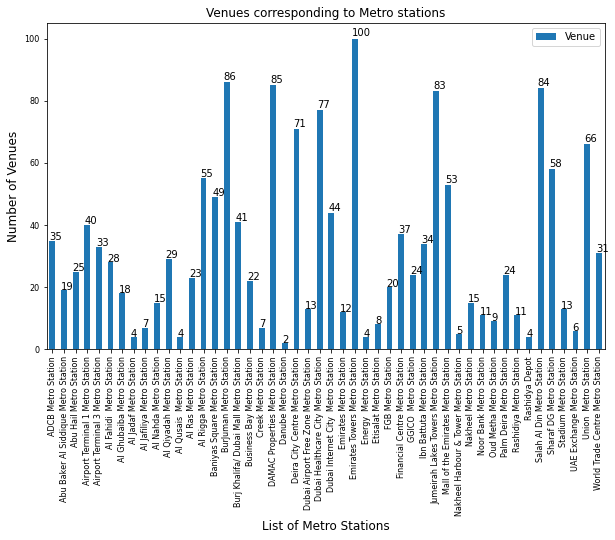

In [13]:
co1=Metro_venues.groupby('Station Name').count()
co=co1.drop(columns=['Venue Category','Station Latitude','Station Longitude','Venue Latitude','Venue Longitude'])
#plot venues corresponding to each station
import matplotlib.pyplot as plt
ax = co.plot(kind='bar', title ="Venues corresponding to Metro stations",figsize=(10,6),legend=True, fontsize=8)
ax.set_xlabel("List of Metro Stations",fontsize=12)
ax.set_ylabel("Number of Venues",fontsize=12)
for co in ax.patches:
    ax.annotate(str(co.get_height()), (co.get_x() * 1.0, co.get_height() * 1.01))

It is observed that several Metro stations have lesser venues, which makes the analysis difficult because these stations lack tourist spots, distant from city limit and are most likely unique when employing clustering algorithm. Therefore Metro stations with less than 25 venues are discarded. The resulting dataframe contains 23 popular Metro stations.

In [14]:
#Drop all the neighborhoods that have less than 25 venues, because they are mostlikely "unique" when using the clustering algorithm 
minVenue=25
VenCount=Metro_venues.groupby('Station Name').count()>=minVenue
VenCount=VenCount[VenCount['Venue']]
# reduce the venues list
Metro_venues_reduce=Metro_venues[Metro_venues['Station Name'].isin(VenCount.index)]
# reduce the Dubai data set
dubai_data_reduce=dubai_data[dubai_data['Station Name'].isin(VenCount.index)]
# one hot encoding
dubai_data_reduce.head()

,Station Name,line,longitude,latitude
1,Abu Hail Metro Station,Green,55.346268,25.275242
2,ADCB Metro Station,Red,55.298196,25.244494
3,Airport Terminal 1 Metro Station,Red,55.352474,25.248428
4,Airport Terminal 3 Metro Station,Red,55.359526,25.245013
5,Al Fahidi Metro Station,Green,55.297559,25.258301


In [15]:
#Total number of popular stations
dubai_data_reduce.shape

(23, 4)

In [16]:
# Datatframe consisting of promising stations
dubai_data_reduce.head()

,Station Name,line,longitude,latitude
1,Abu Hail Metro Station,Green,55.346268,25.275242
2,ADCB Metro Station,Red,55.298196,25.244494
3,Airport Terminal 1 Metro Station,Red,55.352474,25.248428
4,Airport Terminal 3 Metro Station,Red,55.359526,25.245013
5,Al Fahidi Metro Station,Green,55.297559,25.258301


## Analyze Each Metro station

In [17]:
# one hot encoding
dubai_onehot = pd.get_dummies(Metro_venues_reduce[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
dubai_onehot['Station Name'] = Metro_venues_reduce['Station Name'] 
# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]
#dubai_onehot.head()

And let's examine the new dataframe size.

In [18]:
dubai_onehot.shape

(1244, 196)

Next, let's group rows by Stations and by taking the mean of the frequency of occurrence of each category

In [19]:
dubai_grouped = dubai_onehot.groupby('Station Name').mean().reset_index()
dubai_grouped.head()

,Station Name,Accessories Store,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Café,Camera Store,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Cupcake Shop,Currency Exchange,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Music Store,Nail Salon,Nightclub,Noodle House,North Indian Restaurant,Office,Pakistani Restaurant,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Ski Area,Smoke Shop,Snack Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,ADCB Metro Station,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000,0.0,0.0,0.0,0.085714,0.0,0.0,0.028571,0.00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.0,0.028571,0.0,0.000000,0.0,0.000000,0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.028571,0.0,0.0,0.000,0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.000000,0.0,0.057143,0.057143,0.0,0.0,0.000000,0.00,0.0,0.000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000,0.028571,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.028571,0.171429,0.0,0.00,0.0,0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.028571,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.057143,0.0,0.0,0.0,0.000000,0.0,0.000,0.028571,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Let's confirm the new size

In [20]:
dubai_grouped.shape

(23, 196)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Station Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['Station Name'] = dubai_grouped['Station Name']

for ind in np.arange(dubai_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

stations_venues_sorted.head()

,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADCB Metro Station,Indian Restaurant,Hotel,Asian Restaurant,Fast Food Restaurant,Filipino Restaurant,Pakistani Restaurant,Chinese Restaurant,Restaurant,Convenience Store,Department Store
1,Abu Hail Metro Station,Café,Indian Restaurant,Clothing Store,Hotel,Baby Store,Pizza Place,Convenience Store,Fast Food Restaurant,Bus Station,Burrito Place
2,Airport Terminal 1 Metro Station,Airport Terminal,Airport Service,Rental Car Location,Airport Lounge,Coffee Shop,Breakfast Spot,Sandwich Place,Smoke Shop,Food Court,Mobile Phone Shop
3,Airport Terminal 3 Metro Station,Airport Lounge,Coffee Shop,Duty-free Shop,Spa,Hotel,Juice Bar,Clothing Store,Smoke Shop,Burger Joint,Sandwich Place
4,Al Fahidi Metro Station,Indian Restaurant,Asian Restaurant,Pizza Place,North Indian Restaurant,Sporting Goods Shop,Camera Store,Chinese Restaurant,Coffee Shop,Pub,Persian Restaurant


## K-Means Clustering

In this project value of K is obtained from the Elbow method which provides the optimal value of K for the data of our interest. 

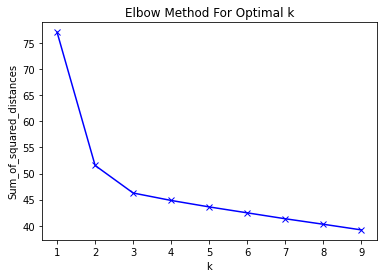

In [23]:
g=pd.get_dummies(dubai_data)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
mms = MinMaxScaler()
mms.fit(g)
data_transformed = mms.transform(g)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


The clustering algorithm employed in this project is one of the most popular unsupervised machine learning algorithms. This algorithm is iterative and uses Euclidean-based similarity measures to cluster the dataset into 2 clusters. 

In [24]:
# set number of clusters
kclusters =2

dubai_grouped_clustering = dubai_grouped.drop('Station Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dubai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [25]:
# add clustering labels
stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

station_merged = dubai_data_reduce

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
station_merged = station_merged.join(stations_venues_sorted.set_index('Station Name'), on='Station Name')

station_merged.head() # check the last columns!

,Station Name,line,longitude,latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Abu Hail Metro Station,Green,55.346268,25.275242,1,Café,Indian Restaurant,Clothing Store,Hotel,Baby Store,Pizza Place,Convenience Store,Fast Food Restaurant,Bus Station,Burrito Place
2,ADCB Metro Station,Red,55.298196,25.244494,1,Indian Restaurant,Hotel,Asian Restaurant,Fast Food Restaurant,Filipino Restaurant,Pakistani Restaurant,Chinese Restaurant,Restaurant,Convenience Store,Department Store
3,Airport Terminal 1 Metro Station,Red,55.352474,25.248428,0,Airport Terminal,Airport Service,Rental Car Location,Airport Lounge,Coffee Shop,Breakfast Spot,Sandwich Place,Smoke Shop,Food Court,Mobile Phone Shop
4,Airport Terminal 3 Metro Station,Red,55.359526,25.245013,0,Airport Lounge,Coffee Shop,Duty-free Shop,Spa,Hotel,Juice Bar,Clothing Store,Smoke Shop,Burger Joint,Sandwich Place
5,Al Fahidi Metro Station,Green,55.297559,25.258301,1,Indian Restaurant,Asian Restaurant,Pizza Place,North Indian Restaurant,Sporting Goods Shop,Camera Store,Chinese Restaurant,Coffee Shop,Pub,Persian Restaurant


#### Display clusters corresponding to Metro stations superimposed on top of folium map

In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(station_merged['latitude'], station_merged['longitude'], station_merged['Station Name'], station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
#Display cluster details based on stations using catplot
cluster_label=station_merged[["Station Name","Cluster Labels","1st Most Common Venue"]].reset_index()
cluster_display=cluster_label.drop(columns='index')


#### Visualize cluster labels using catplot

Cluster 0 comprises of arbitrary venues which is out of scope. It is observed that hotel, restaurants, coffee shop and café categories fall under Cluster 1 which is the prominent feature in this study. 

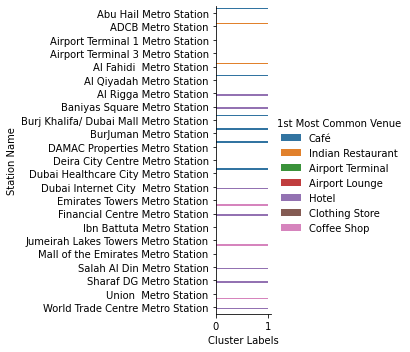

In [28]:
sns.catplot(y="Station Name", x="Cluster Labels", hue="1st Most Common Venue", kind="bar", data=cluster_display);
plt.show()

In [29]:
#Cluster 0 
cluster0=station_merged.loc[station_merged['Cluster Labels'] == 0, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]
cluster0

,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Airport Terminal 1 Metro Station,Airport Terminal,Airport Service,Rental Car Location,Airport Lounge,Coffee Shop,Breakfast Spot,Sandwich Place,Smoke Shop,Food Court,Mobile Phone Shop
4,Airport Terminal 3 Metro Station,Airport Lounge,Coffee Shop,Duty-free Shop,Spa,Hotel,Juice Bar,Clothing Store,Smoke Shop,Burger Joint,Sandwich Place
22,Deira City Centre Metro Station,Clothing Store,Coffee Shop,Hotel,Café,Electronics Store,Chinese Restaurant,Jewelry Store,Ice Cream Shop,Middle Eastern Restaurant,Bar
33,Ibn Battuta Metro Station,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Shopping Mall,Seafood Restaurant,Kids Store,Bowling Alley,Sandwich Place,Bookstore,Salon / Barbershop
35,Mall of the Emirates Metro Station,Clothing Store,Café,Cosmetics Shop,Movie Theater,Chinese Restaurant,Lounge,Hotel,Boutique,Coffee Shop,Ski Area


In [30]:
#Cluster 1 
cluster1=station_merged.loc[station_merged['Cluster Labels'] == 1, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]
cluster1.head()

,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Abu Hail Metro Station,Café,Indian Restaurant,Clothing Store,Hotel,Baby Store,Pizza Place,Convenience Store,Fast Food Restaurant,Bus Station,Burrito Place
2,ADCB Metro Station,Indian Restaurant,Hotel,Asian Restaurant,Fast Food Restaurant,Filipino Restaurant,Pakistani Restaurant,Chinese Restaurant,Restaurant,Convenience Store,Department Store
5,Al Fahidi Metro Station,Indian Restaurant,Asian Restaurant,Pizza Place,North Indian Restaurant,Sporting Goods Shop,Camera Store,Chinese Restaurant,Coffee Shop,Pub,Persian Restaurant
10,Al Qiyadah Metro Station,Café,Middle Eastern Restaurant,Convenience Store,Restaurant,Thai Restaurant,Hotel,Yemeni Restaurant,Hookah Bar,Gym,Kebab Restaurant
13,Al Rigga Metro Station,Hotel,Middle Eastern Restaurant,Coffee Shop,Filipino Restaurant,Restaurant,Sandwich Place,Café,Bar,Fast Food Restaurant,Kurdish Restaurant


In [35]:
#extract datas of cluster 1 from Metro_venues_reduce
options=cluster1["Station Name"]
rslt_1 = Metro_venues_reduce[Metro_venues_reduce['Station Name'].isin(options)] 
#extract all restaurant/Hotel
allrest=rslt_1[rslt_1['Venue Category'].str.contains("Restaurant|Hotel")].drop(columns=['Venue','Station Latitude','Station Longitude','Venue Latitude','Venue Longitude'])
#rename columns
allrest.rename(columns={'Venue Category':'Other Restaurants/Hotels'},inplace=True)
#group based on stations
allrest=allrest.groupby('Station Name').count()
#extract Indian restaurant
indrest=rslt_1[rslt_1['Venue Category'].str.contains("Indian Restaurant")].drop(columns=['Venue','Station Latitude','Station Longitude','Venue Latitude','Venue Longitude'])
#rename columns
indrest.rename(columns={'Venue Category':'Indian Restaurant'},inplace=True)
#group based on stations
indrest=indrest.groupby('Station Name').count()
#merge 2 dataframes
count_rest =pd.merge( allrest,indrest , on='Station Name', how='outer').fillna("0").astype(int)
count_rest.head()


,Other Restaurants/Hotels,Indian Restaurant
Station Name,,
ADCB Metro Station,26,6
Abu Hail Metro Station,6,2
Al Fahidi Metro Station,16,8
Al Qiyadah Metro Station,15,0
Al Rigga Metro Station,34,0


#### Comparison of Indian restaurants with Other restaurants/Hotels

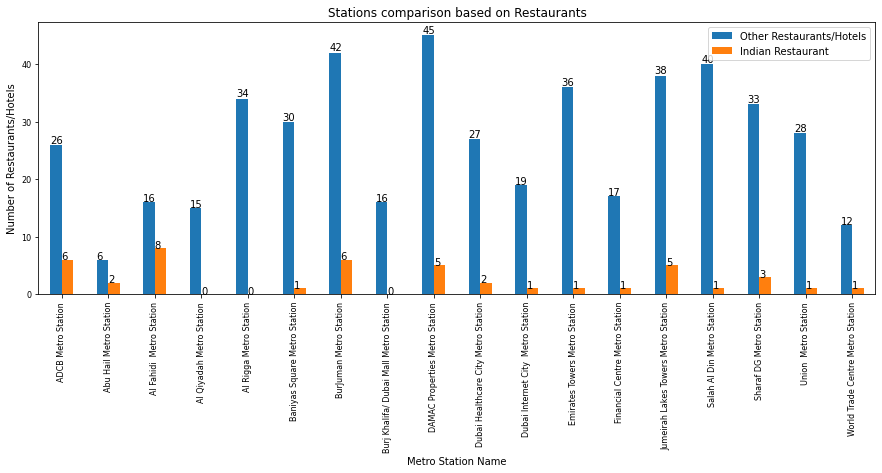

In [32]:
import matplotlib.pyplot as plt
ax = count_rest.plot(kind='bar', title ="Stations comparison based on Restaurants", figsize=(15, 5), legend=True, fontsize=8)
ax.set_xlabel("Metro Station Name", fontsize=10)
ax.set_ylabel("Number of Restaurants/Hotels", fontsize=10)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() * 1.0, i.get_height() * 1.01))


### Heatmap Visualization

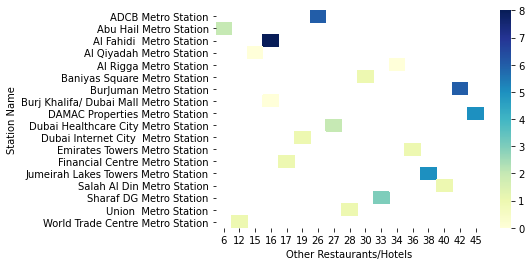

In [33]:
heatmap_data = pd.pivot_table(count_rest, values='Indian Restaurant',index=['Station Name'],columns='Other Restaurants/Hotels')
sns.heatmap(heatmap_data, cmap="YlGnBu")

In order to draw a conclusion for optimal location for the Business, let us visualize the intensity of Indian restaurant density with the Heat map. In this case, the heatmap represents matrix wherein each column represent the total number of restaurants/hotels corresponding to each Metro stations represented in the row. Each square of the heatmap represents a cell which displays density of Indian restaurants ranging from low to high density value.

From the above figure, we observe that Al Qiyadah Metro station, Al Rigga Metro station and Burj Khalifa Metro station has lower density of Indian restaurants making it an ideal location to set up the business. However, there are various factors that can influence the decision. Let us analyze each station in this zone from a business prospective. We have noticed that Burj Khalifa Metro station is Dubai’s downtown with prominent attractions making it one of the top tourist destinations in the world. The House price index is extremely high for this locality, involving premium cost for business setup. Al Rigga Metro station has high population density with low house price index, making it most suitable for the business. Whereas Al Qiyadah Metro station has low House price index, mostly industrial area and located far away from the city limits making it not a great location for the business.

The heat map also reveals stations such as Baniyas Square Metro station, Dubai Internet City Metro station, Emirates Tower Metro station, Financial Centre Metro station, Salah Al Din Metro station, Union Metro station and World Trade Centre Metro station has lower density of Indian restaurants making it a second ideal locations. Let us analyze each station in this zone from a business prospective. Baniyas Square has a lot of tourist attraction with higher population density and low House price index making an ideal location for Business. Whereas Emirates Tower, Financial Centre and World Trade Centre fall under one stretch in metro line closer to downtown area having high House price index. Thus population density is lower in these regions making it less feasible area of interest for business. Dubai Internet City is dedicated to Information Technology sectors having low population density therefore not an ideal location for restaurant business. We have noticed mostly coffee shops and café category in this region. Salah Al Din Metro station and Union Metro come under same metro line and are located less than 1 km radius. These two stations have high density of population with mid-level House price index making it significant and affordable location with plenty of tourist attractions in the vicinity.

Abu Hail Metro station, Dubai Healthcare City Metro station and Sharaf DG Metro station falls under third optimal location with mid-density of Indian restaurant in the region. Let us analyze each station in this zone from a business prospective. Abu Hail is densely populated with low income households having low House price index. We have found that this area is not a tourist spot, thus making it an ideal location for a low budget business setup. Dubai Healthcare city is dedicated healthcare freezone area with less tourist spots. However, population density in this area is very low due to high House pricing index. Sharaf DG has high population density having residential area with reasonable House price index. This could be an ideal location for setting up the business.

 All other stations shown in the hottest region in the heat map with highest density of Indian restaurants will not the best suit for business.


## Results and Discussions <a name="results"></a>

The dataset for Dubai Metro, both Red and Green lines had 1544 venues belonging to 221 unique categories. The venues were selected within a range of 500 meter radius from each metro station which was retrieved using Foursquare geopy service. By employing clustering algorithm, Metro stations were clustered to obtain zones of interest. Since our objective is to find the best location for an Indian restaurant, we have chosen cluster belonging to ‘food’ venue category for this research. This primarily contains hotels, restaurants, cafes and coffee shops. As per the study, large numbers of restaurant were detected in red line Metro and few restaurants in the green line Metro. It is observed that several Metro stations have lesser venues, which makes the analysis difficult because these stations lack tourist spots, distant from city limit and are most likely unique when employing clustering algorithm. Therefore Metro stations with less than 25 venues were discarded.

This study intends to find the optimal location for restaurant business. The following category like coffee shops, café’s, Pizza shops are not considered as our direct competitors therefore these were eliminated from the research and have selected only “other restaurants/hotels” category for the analysis. This enables the research to locate the optimal location to setup an Indian restaurant. Further we perform analysis based on popular tourist attractions, population density and House price index for the station which has low Indian restaurant density as depicted from the heatmap. The entire hot region in the heatmap corresponding to high Indian restaurant density was withdrawn from the research.

To draw the inference, recommended zones must be considered as a jump off point for a detailed study as it will eventually summarize the location where relevant factors are taken into consideration with less/no competition.


## Conclusion <a name="conclusion"></a>

The objective of this project was to detect the optimal location for Indian restaurants within 500 meter radius with less or no competition. By considering restaurant density distribution from heatmap, we have identified several potential candidate stations by looking at Population density, popular tourist attractions and House price index with no/less competitions which will aid stakeholders in tapering the search for the most favorable business investment. The final decision in deriving on optimal location is solely based on their preferences.